# Collaborative Filtering
### Using sampled data

In [2]:
import pandas as pd
import numpy as np

In [4]:
X_train = pd.read_csv('data/train_x.csv')
Y_train = pd.read_csv('data/train_y.csv', header=None, names=['target'])
X_test = pd.read_csv('data/test_x.csv')
Y_test = pd.read_csv('data/test_y.csv', header=None, names=['target'])

In [43]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion
from sklearn.random_projection import sparse_random_matrix
from sklearn.metrics import accuracy_score, auc, roc_curve, recall_score, f1_score, mean_squared_error, precision_score
import scipy as sp

In [6]:
X = X_train.append(X_test, ignore_index=True)
Y = Y_train.append(Y_test, ignore_index=True)
X.shape

(50000, 17)

In [13]:
data = pd.concat([X[['msno', 'song_id']], Y], axis=1) 

In [6]:
# Categorical features
cat = ['source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name', 'language', 'song_country', 'city', 'registered_via']
X_cat_features = X[cat]

X_cat_features['language'] = X_cat_features['language'].astype('category')
X_cat_features['city'] = X_cat_features['city'].astype('category')
X_cat_features['registered_via'] = X_cat_features['registered_via'].astype('category')

C:\Dev\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Dev\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Dev\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Populate dummy +variables for categorical features
df = pd.get_dummies(X_cat_features, prefix=['sst', 'ssn', 'st', 'gen', 'arts', 'lang', 'natl', 'city', 'rgtvia'])

In [8]:
# Add numerical features to the categorical features (with dummies)
df2 = pd.concat([X[['msno', 'song_id', 'registration_init_time', 'expiration_date', 'duration', 'song_length', 'song_year']], df], axis=1)

In [9]:
# We use the dataset after the preprocessing
X = df2

In [10]:
X.shape
# The number of columns increased
# because of the categorical variables with dummy variables

(50000, 5774)

In [11]:
# It's been shuffled in the first place,
# so I can split like this.
X_train = X[:37500]
X_test = X[37500:]

## PCA

In [12]:
col_pca = X.columns.values.tolist()
# These two columns will be added after PCA
col_pca.remove('msno')
col_pca.remove('song_id')

In [13]:
# Check missing value for each column
# X_train[col_pca].isnull().any()[X_train[col_pca].isnull().any()==True]
X_train[col_pca].isnull().sum().sum()

0

In [14]:
# Scaling using Standard Sclaer
scaler = StandardScaler().fit(X_train[col_pca])
X_train_transformed = scaler.transform(X_train[col_pca])
X_test_transformed = scaler.transform(X_test[col_pca])

# Shape of the training data
print('Shape of the training data before PCA : ', X_train_transformed.shape)

exp = []
for n in [10, 100, 1000]:
    # Apply PCA using two principle components
    pca = PCA(n_components=n)
    Data_pca = pca.fit(X_train_transformed)

    X_train_pca = pca.transform(X_train_transformed)
    X_test_pca  = pca.transform(X_test_transformed)

    print('Shape of the training data after PCA :  ', X_train_pca.shape)
    #print('Explined variance,', Data_pca.explained_variance_ratio_)
    exp.append([n, Data_pca.explained_variance_ratio_.sum()])
    
print(exp)

Shape of the training data before PCA :  (37500, 5772)
Shape of the training data after PCA :   (37500, 10)
Shape of the training data after PCA :   (37500, 100)
Shape of the training data after PCA :   (37500, 1000)
[[10, 0.0071058171942342532], [100, 0.044121102814816619], [1000, 0.245675739216213]]


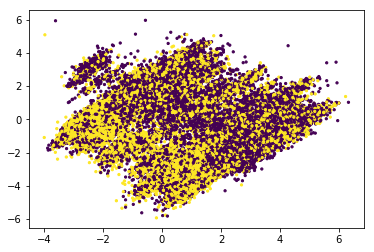

In [16]:
# 2-d scatter plot for PCA with 2 PCs
pca = PCA(n_components=2)
Data_pca = pca.fit(X_train_transformed)

X_train_pca = pca.transform(X_train_transformed)
X_test_pca  = pca.transform(X_test_transformed)

pc1 = X_train_pca[:,0]
pc2 = X_train_pca[:,1]

plt.scatter(pc1, pc2, c=Y_train, s=5) # target 0: blue, target 1: red
plt.show()

*Conclusion:*
The information explained after PCA is too small. Only 4% of original data is explained by 100 principle componet vectors. It's assumed that it's because of the data is sparse. PCA is believed not to fit to our problem.

## CF
- http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [8]:
data.shape

(50000, 3)

In [15]:
data.columns = ['user_id', 'item_id', 'rating']

In [16]:
data['rating'] = data['rating']+1

In [17]:
data['rating'].value_counts()

2    25202
1    24798
Name: rating, dtype: int64

In [18]:
n_users = len(data.user_id.unique())
n_items = len(data.item_id.unique())
users = list(data['user_id'].unique())
items = list(data['item_id'].unique())

print(str(n_users) + ' users')
print(str(n_items) + ' items')

16537 users
21186 items


## Collaborative Filtering
#### Nearest Neighbor Method by Surprise package

In [22]:
from surprise import KNNBasic, Reader, SVD, KNNWithMeans
from surprise import Dataset, accuracy
from surprise import PredictionImpossible
from surprise import GridSearch

In [23]:
X_test = X_test.reset_index(drop=True)

In [24]:
# User only 'msno', 'song_id', 'target
# Get a train and validation set. And get a test set
train = pd.concat([X_train[['msno', 'song_id']], Y_train['target']], axis=1)
test = pd.concat([X_test[['msno', 'song_id']], Y_test['target']], axis=1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [25]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(37500, 17) (12500, 17) (37500, 1) (12500, 1)


### Cross Validation

In [31]:
# import the train data for cross validation
reader = Reader(rating_scale=(0,1))
tr=Dataset.load_from_df(train, reader)
tr.split(n_folds=5) # 5-fold cross validation

# SVD
algo = SVD() # main algorithm
# Cross validation
rmse=[]
for trainset, testset in tr.folds():
    algo.train(trainset) # fit data
    predictions = algo.test(testset, verbose=False) # predict ratings
    rmse.append(accuracy.rmse(predictions))
print("Cross validated RMSE: ", np.mean(rmse))

RMSE: 0.4976
RMSE: 0.4966
RMSE: 0.4981
RMSE: 0.4958
RMSE: 0.4977
Cross validated RMSE:  0.497163683666


### Test on test dataset
#### Using SVD (Matrix Factorization)

In [127]:
# Re-run the model with the whole training set
reader = Reader(rating_scale=(0,1))
tr=Dataset.load_from_df(train, reader)
tr=tr.build_full_trainset() # train from the full training set

algo = KNNBasic()
algo.train(tr)

print("Test set shape:", test.shape)
# Load test set
for i in test.index:
    test.loc[i, 'est'] = algo.predict(test['msno'][i], test['song_id'][i], r_ui=test['target'][i])[3] # estimate

Computing the msd similarity matrix...
Done computing similarity matrix.
Test set shape: (12500, 3)


In [32]:
# Re-run the model with the whole training set
reader = Reader(rating_scale=(0,1))
tr=Dataset.load_from_df(train, reader)
tr=tr.build_full_trainset() # train from the full training set

algo = SVD()
algo.train(tr)

print("Test set shape:", test.shape)
# Load test set
for i in test.index:
    test.loc[i, 'est_svd'] = algo.predict(test['msno'][i], test['song_id'][i], r_ui=test['target'][i])[3] # estimate

Test set shape: (12500, 4)


In [34]:
test.loc[test['est_svd']>=0.5, 'est_svd_target']=1
test.loc[test['est_svd']<0.5, 'est_svd_target']=0

In [35]:
test['est_svd_target'] = test['est_svd_target'].astype(np.int8)
test['target'] = test['target'].astype(np.int8)

In [39]:
PredictedOutput = test['est_svd_target']
Y_test = test['target']

In [ ]:
precision_sco

In [44]:
test_accuracy = accuracy_score(Y_test, PredictedOutput)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
test_precision = precision_score(Y_test, PredictedOutput)
test_f1 = f1_score(Y_test, PredictedOutput)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_rmse = np.sqrt(mean_squared_error(Y_test, PredictedOutput))
test_auc = auc(fpr, tpr)

print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)
print("Test f1-score: ", test_f1)
print("Test AUC: ", test_auc)
print("Test RMSE: ", test_rmse)

Test Accuracy:  0.55912
Test Precision:  0.552178043154
Test Recall:  0.647929936306
Test f1-score:  0.596234156348
Test AUC:  0.558691656256
Test RMSE:  0.663987951698
